<a href="https://colab.research.google.com/github/sp-au-mu-nl/PythonMedia/blob/main/notebook/chap11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/sp-au-mu-nl/PythonMedia/raw/refs/heads/main/data/chap11.zip
!unzip chap11.zip
!rm chap11.zip

--2025-06-26 07:17:33--  https://github.com/sp-au-mu-nl/PythonMedia/raw/refs/heads/main/data/chap11.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/PythonMedia/refs/heads/main/data/chap11.zip [following]
--2025-06-26 07:17:33--  https://raw.githubusercontent.com/sp-au-mu-nl/PythonMedia/refs/heads/main/data/chap11.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4574975 (4.4M) [application/zip]
Saving to: ‘chap11.zip’

chap11.zip          100%[===================>]   4.36M  --.-KB/s    in 0.09s   

2025-06-26 07:17:34 (49.4 MB/s) - ‘chap11.zip’ saved [4574975/4574975]

Archive:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import multivariate_normal
import cv2
import librosa
import plotly.express as px

In [3]:
%%writefile zcr.py
import numpy as np

def zcr(y,tau,fs):
  sc=y.shape[0]/fs/tau
  zc=np.abs(np.diff(np.sign(y),axis=0)).sum(axis=0)/2/sc
  return(zc)

Writing zcr.py


In [4]:
%%writefile frameindex.py
import numpy as np
def frameindex(framelength, noverlap, signallength):
  sft=framelength-noverlap
  n=np.int16(np.fix((signallength-framelength)/sft+1))
  findex=np.array([np.arange(0,framelength)]).T \
                  +np.array([np.arange(0,n)])*sft
  return(findex)

Writing frameindex.py


In [5]:
from frameindex import frameindex
from zcr import zcr
m,fs=librosa.load('minami16.wav',sr=None)
F2=m[frameindex(512,256,m.shape[0])]
Z2=zcr(F2,0.01,fs)
E2=np.log(np.sum(F2**2,axis=0))
dnum=Z2.shape[0]
snd=np.arange(99,143)
slc=np.setdiff1d(np.arange(0,dnum),snd)
X=np.vstack((Z2,E2)).T
y=np.array(['silence']*dnum)
y[snd]='sound'
ngh=KNeighborsClassifier(n_neighbors=5)
ngh.fit(X,y)

KNeighborsClassifier()

In [6]:
sum(ngh.predict(X)!=y)/X.shape[0]

np.float64(0.02459016393442623)

In [7]:
B1=cv2.imread('20140312_B4.pgm',-1)
h,w=B1.shape
I=np.zeros((h,w,3))
I[:,:,0]=B1
I[:,:,1]=cv2.imread('20140312_B3.pgm',-1)
I[:,:,2]=cv2.imread('20140312_B2.pgm',-1)
px.imshow(np.uint8(I/np.max(I)*255)*3)

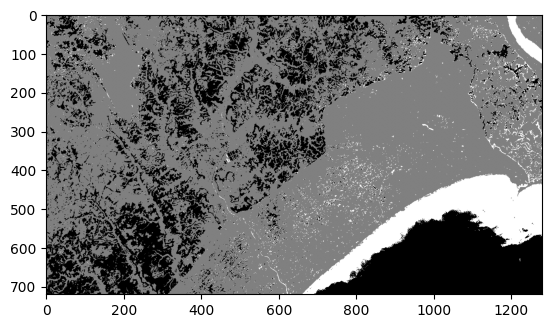

In [8]:
dk=I[102:108,31:35]
sl=I[684:689,547:553]
sa=I[480:486,987:997]
sp1=dk.shape
sp2=sl.shape
sp3=sa.shape
X1=dk.reshape((sp1[0]*sp1[1],sp1[2]))
X2=sl.reshape((sp2[0]*sp2[1],sp2[2]))
X3=sa.reshape((sp3[0]*sp3[1],sp3[2]))
c1=np.array(['dark']*X1.shape[0])
c2=np.array(['soil']*X2.shape[0])
c3=np.array(['sea']*X3.shape[0])
ngh=KNeighborsClassifier(n_neighbors=5)
ngh.fit(np.vstack((X1,X2,X3)),np.hstack((c1,c2,c3)))
X=I.reshape((I.shape[0]*I.shape[1],I.shape[2]))
pr=ngh.predict(X).reshape((I.shape[0],I.shape[1]))
R=np.zeros((I.shape[0],I.shape[1]))
R[pr=='dark']=80
R[pr=='soil']=160
R[pr=='sea']=240
plt.imshow(R,cmap='gray')

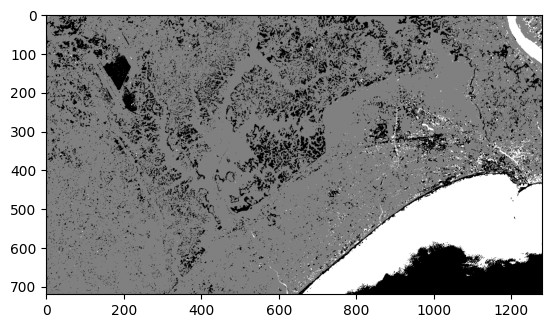

In [9]:
mm_dk=np.mean(X1,axis=0)
mm_sl=np.mean(X2,axis=0)
mm_sa=np.mean(X3,axis=0)
ss_dk=np.cov(X1,rowvar=False)
ss_sl=np.cov(X2,rowvar=False)
ss_sa=np.cov(X3,rowvar=False)
p_dk=multivariate_normal.pdf(X,mm_dk,ss_dk)
p_sl=multivariate_normal.pdf(X,mm_sl,ss_sl)
p_sa=multivariate_normal.pdf(X,mm_sa,ss_sa)
plt.imshow(np.argmax(np.vstack((p_dk,p_sl,p_sa)),
                     axis=0).reshape((h,w))*80,cmap='gray')